In [1]:
import spacy
import json
import gensim
from collections import Counter
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from pprint import pprint
import numpy as np
np.random.seed(2042)

import pandas as pd
pd.options.display.max_colwidth = 400

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import logging
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)

import pyLDAvis
import pyLDAvis.gensim_models

from wordcloud import WordCloud

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

import seaborn as sns

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
[nltk_data] Downloading package wordnet to /Users/harshit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harshit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## READ FINANCIAL DATA

In [4]:
url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-03-30&date_received_min=2021-02-28&field=all&format=csv&has_narrative=true&no_aggs=true&size=18102"
df_all = pd.read_csv(url)

# In this example, we take only the first 1000 complaints in the dataset for further analysis. 
# Set df to df_all to run on the complete dataset.
df_small = df_all.tail(1000)
df = df_small
df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
17124,03/11/21,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute about a purchase on your statement,Opened a fraudulent case with bank of America and after sitting on it for 3 months decided they were our charges and I submitted paperwork from XXXX stating these order don't exist or anything shipped to my house with the order numbers provided they said the verified with XXXX which was a lie as XXXX won't give any info to them without my knowledge and they tried to say they traced it to my ip...,Company has responded to the consumer and the CFPB and chooses not to provide a public response,"BANK OF AMERICA, NATIONAL ASSOCIATION",NJ,07734,None,Consent provided,Web,03/11/21,Closed with explanation,Yes,NaN,4204331
17125,03/23/21,Mortgage,FHA mortgage,Struggling to pay mortgage,None,"Told at the beginning of COVID-19 pandemic I would be eligible to put my account in forbearance once out of forbearance missed payments would be able to be added to the end of my loan. Spoke with a rep today ( XX/XX/21 ) and found out that they would not honor that and I needed to pay {$16000.00} out of pocket, do a loan modification which would increase payments, interest rate, and/or length ...",None,Home Point Financial Corporation,OH,45345,Servicemember,Consent provided,Web,03/23/21,Closed with explanation,Yes,NaN,4237389
17126,03/24/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Account status incorrect,XXXX ; Experian and XXXX are not investigating the negative accounts reporting on my credit report. I have sent numerous letters to the bureaus requesting an investigation into the false reporting of these accounts and I have never received ANY communication from the bureaus to show that my requests are being looked into. My most recent credit report shows the following accounts as not in di...,Company has responded to the consumer and the CFPB and chooses not to provide a public response,Experian Information Solutions Inc.,NV,89115,None,Consent provided,Web,03/24/21,Closed with explanation,Yes,NaN,4241920


# Visualization

## 1. Product Distribution

<AxesSubplot:>

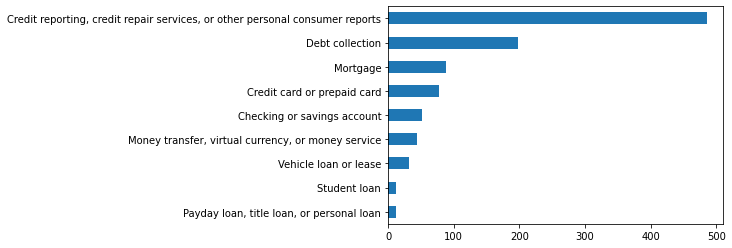

In [5]:
df['Product'].value_counts().sort_values().plot(kind='barh') 

## 2. Issue Distribution

<AxesSubplot:>

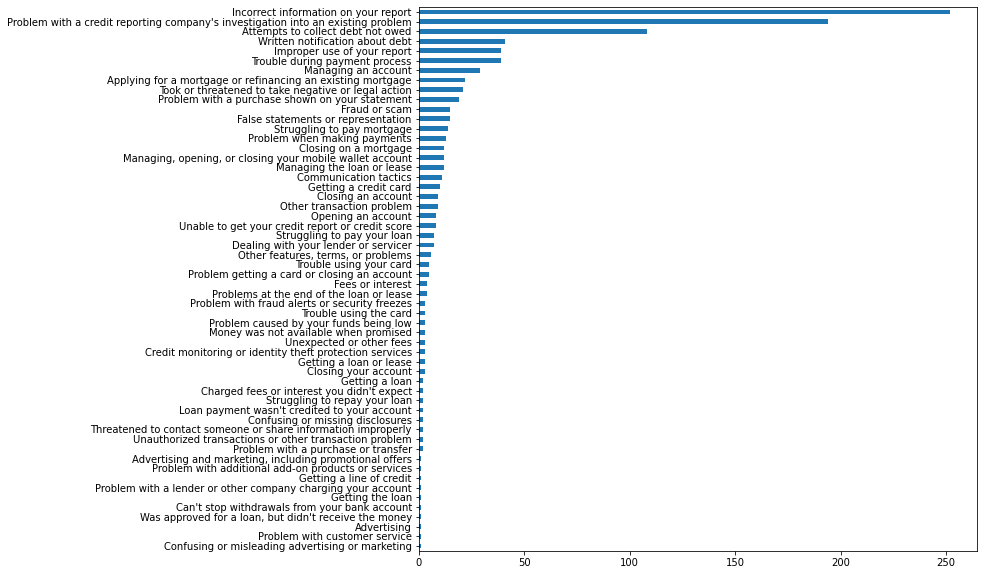

In [6]:
df['Issue'].value_counts().sort_values().plot(kind='barh', figsize=(10,10)) 

# 3. Company Distribution

<AxesSubplot:>

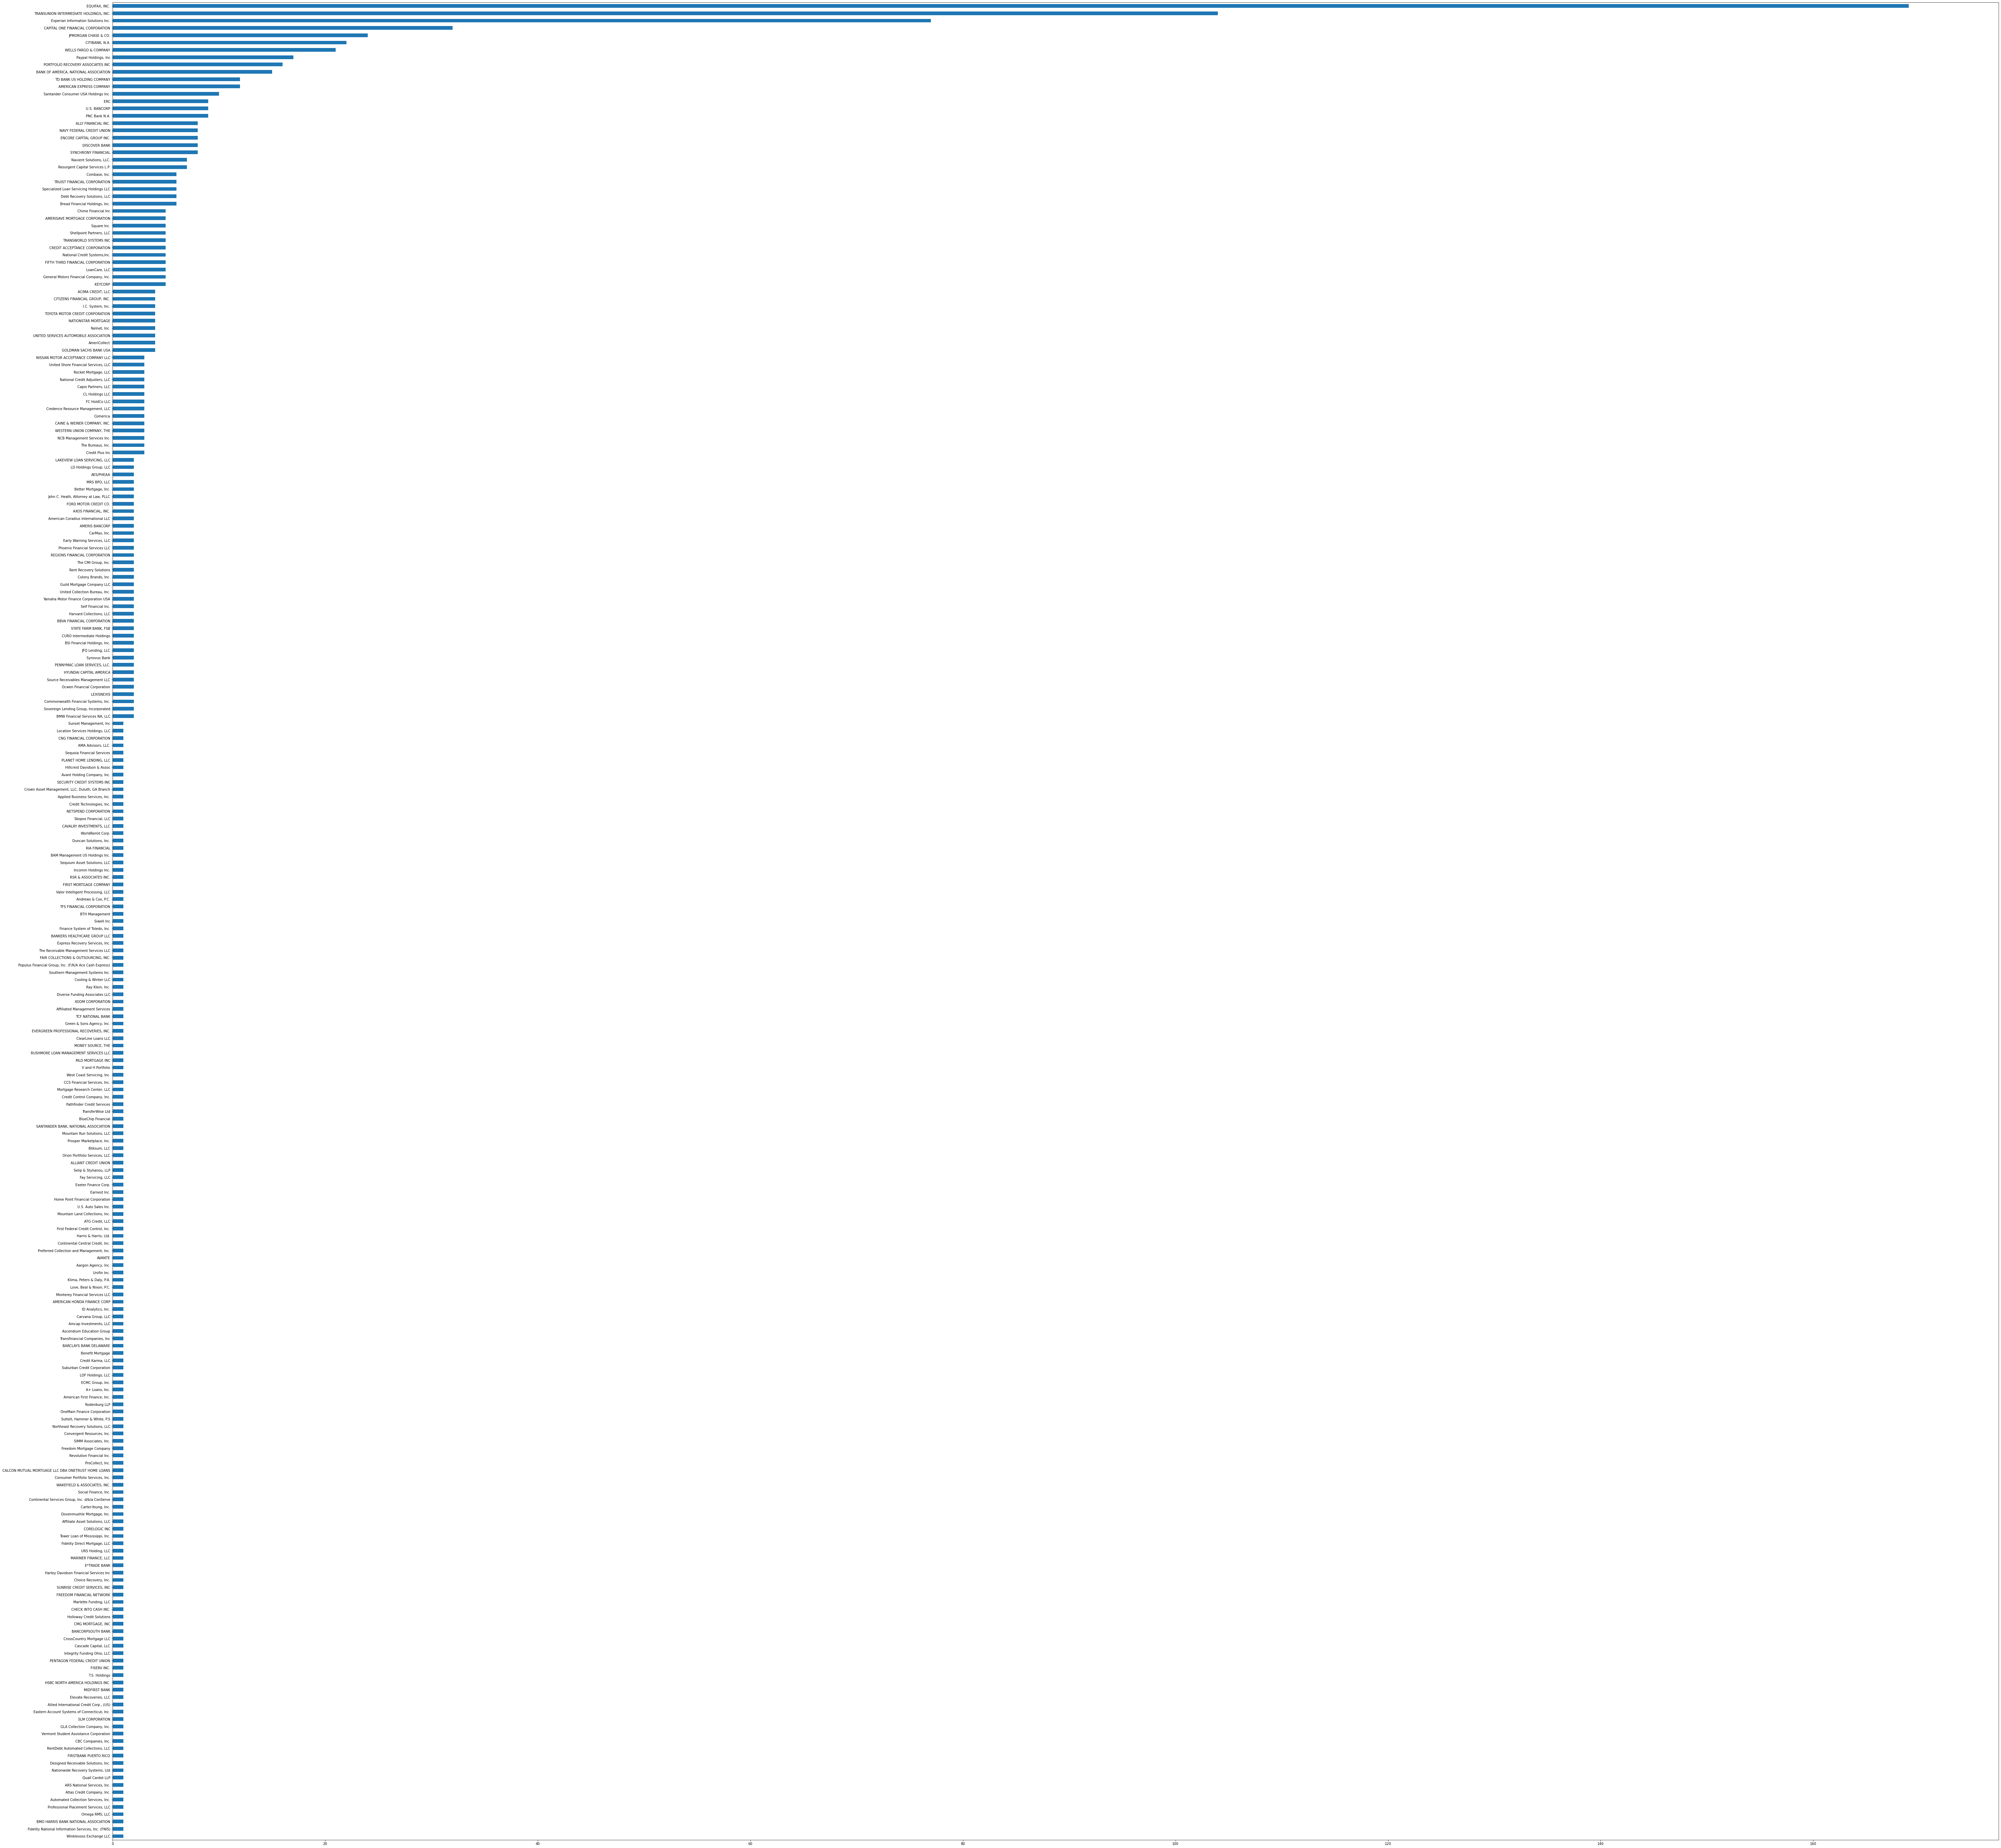

In [7]:
df['Company'].value_counts().sort_values().plot(kind='barh', figsize=(100,100)) 

## 4. State Distribution

<AxesSubplot:>

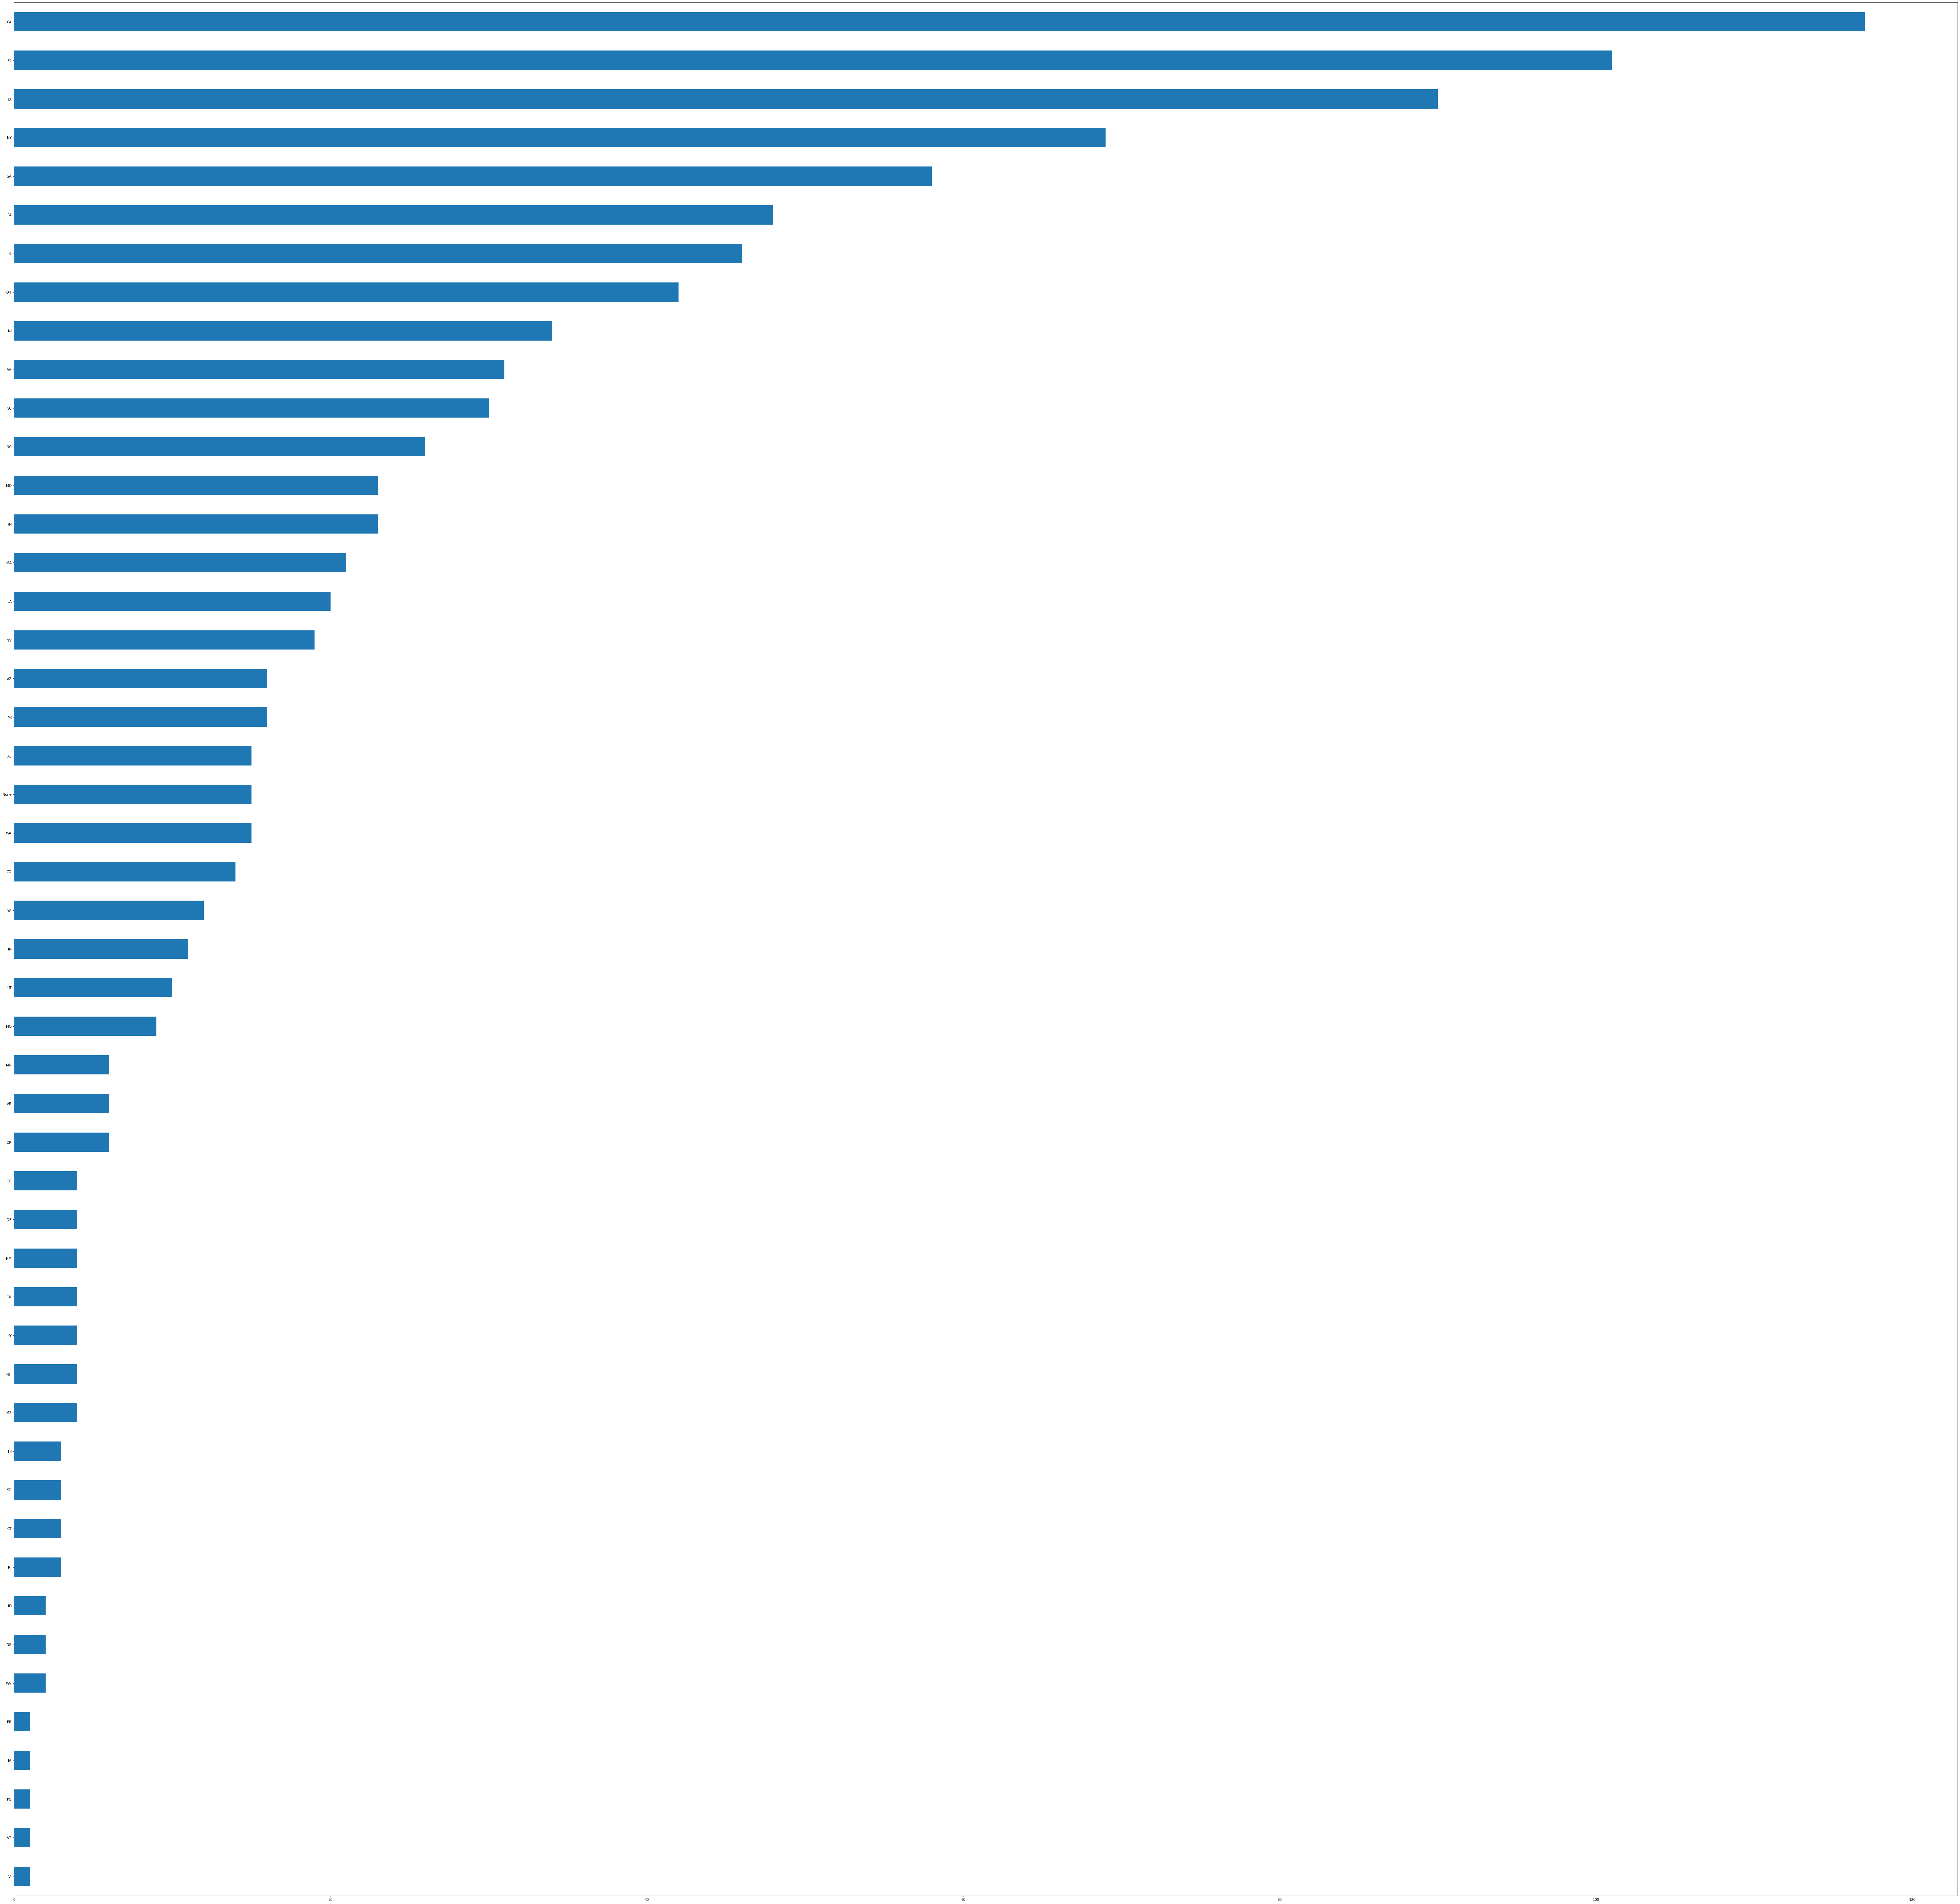

In [8]:
df['State'].value_counts().sort_values().plot(kind='barh', figsize=(100,100)) 

- Consumer complains are under the column `Consumer complaint narrative`. 
- We will focus on text contained in this column.
- Goal is to determine topics in this corpus
- predict topic for each complaint

In [14]:
text_col = 'Consumer complaint narrative'
dataset = df[text_col].to_list()
print("# of records", len(dataset))
print(dataset[0])

# of records 1000
Opened a fraudulent case with bank of America and after sitting on it for 3 months decided they were our charges and I submitted paperwork from XXXX stating these order don't exist or anything shipped to my house with the order numbers provided they said the verified with XXXX which was a lie as XXXX won't give any info to them without my knowledge and they tried to say they traced it to my ip address and I run a ip vanish program


- The input to function `sent_to_words` is a `list of sentences`
- output is a list of list
- each list contains tokens after removing emails,new lines, single quotes, and special symbol `XXX`

In [18]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub(r'\s*\bX+\b\s*', ' ', sent)
        sent = sent.strip()
#         sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 

<>:6: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \s
/var/folders/k0/tdjkjj3942vdpnc33747lk2c0000gn/T/ipykernel_66008/2676965833.py:6: DeprecationWarning: invalid escape sequence \s
  sent = re.sub('\s+', ' ', sent)  # remove newline chars


In [19]:
data_words = list(sent_to_words(dataset))
print(data_words[0])

['opened', 'fraudulent', 'case', 'with', 'bank', 'of', 'america', 'and', 'after', 'sitting', 'on', 'it', 'for', 'months', 'decided', 'they', 'were', 'our', 'charges', 'and', 'submitted', 'paperwork', 'from', 'stating', 'these', 'order', 'dont', 'exist', 'or', 'anything', 'shipped', 'to', 'my', 'house', 'with', 'the', 'order', 'numbers', 'provided', 'they', 'said', 'the', 'verified', 'with', 'which', 'was', 'lie', 'as', 'wont', 'give', 'any', 'info', 'to', 'them', 'without', 'my', 'knowledge', 'and', 'they', 'tried', 'to', 'say', 'they', 'traced', 'it', 'to', 'my', 'ip', 'address', 'and', 'run', 'ip', 'vanish', 'program']


# What does the following code snippet do?

- remove stop words from each complaint
- combine tokens into bigrams

In [20]:
bigram = gensim.models.Phrases(data_words, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
#     texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
#     texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [21]:
data_ready = process_words(data_words)
print("Ex: Consumer Complaint as list of tokens => \n",data_ready[0])

Ex: Consumer Complaint as list of tokens => 
 ['open', 'fraudulent', 'case', 'sit', 'month', 'decide', 'charge', 'submit', 'paperwork', 'state', 'order', 'exist', 'ship', 'house', 'order', 'number', 'provide', 'verify', 'lie', 'give', 'info', 'knowledge', 'trace', 'ip', 'address', 'ip', 'vanish', 'program']


## Create dictionary
## <u> Bag of Words</u> Representation for each Complaint

In [22]:
id2word = Dictionary(data_ready)
corpus = [id2word.doc2bow(text) for text in data_ready]

In [23]:
bow_doc_0 = corpus[0]
print("\nBOW DOCUMENT=>\n",bow_doc_0)
for i in range(len(bow_doc_0)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_0[i][0], 
                                               id2word[bow_doc_0[i][0]], bow_doc_0[i][1]))


BOW DOCUMENT=>
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]
Word 0 ("address") appears 1 time.
Word 1 ("case") appears 1 time.
Word 2 ("charge") appears 1 time.
Word 3 ("decide") appears 1 time.
Word 4 ("exist") appears 1 time.
Word 5 ("fraudulent") appears 1 time.
Word 6 ("give") appears 1 time.
Word 7 ("house") appears 1 time.
Word 8 ("info") appears 1 time.
Word 9 ("ip") appears 2 time.
Word 10 ("knowledge") appears 1 time.
Word 11 ("lie") appears 1 time.
Word 12 ("month") appears 1 time.
Word 13 ("number") appears 1 time.
Word 14 ("open") appears 1 time.
Word 15 ("order") appears 2 time.
Word 16 ("paperwork") appears 1 time.
Word 17 ("program") appears 1 time.
Word 18 ("provide") appears 1 time.
Word 19 ("ship") appears 1 time.
Word 20 ("sit") appears 1 time.
Word 21 ("state") appears 1 time.
Word 22 ("

In [25]:
print("Consumer Complaint as list of tokens (unigram or bigram) =>\n",data_ready[0])

longText = [' '.join(dr) for dr in data_ready]
print("\nConsumer Complaint =>\n",longText[0])

realy_log_Text = ' '.join(longText)

Consumer Complaint as list of tokens (unigram or bigram) =>
 ['open', 'fraudulent', 'case', 'sit', 'month', 'decide', 'charge', 'submit', 'paperwork', 'state', 'order', 'exist', 'ship', 'house', 'order', 'number', 'provide', 'verify', 'lie', 'give', 'info', 'knowledge', 'trace', 'ip', 'address', 'ip', 'vanish', 'program']

Consumer Complaint =>
 open fraudulent case sit month decide charge submit paperwork state order exist ship house order number provide verify lie give info knowledge trace ip address ip vanish program


## Generate Word Cloud of all the terms in the consumer complaints

/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be remov

/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be remov

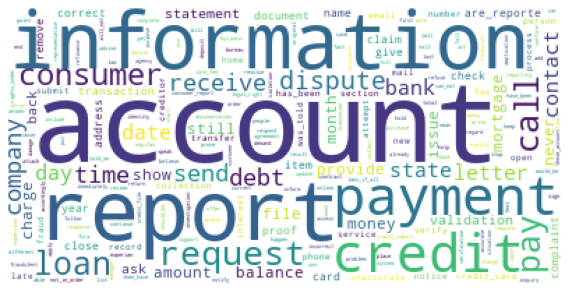

In [26]:
# generate the word cloud
wordcloud = WordCloud(background_color="white",
                      max_words= 500,
                      contour_width = 8,
                      contour_color = "steelblue",
                     collocations=False).generate(realy_log_Text)
# visualize the word cloud
fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Word Distribution across all consumer complaints

<AxesSubplot:xlabel='words', ylabel='count'>

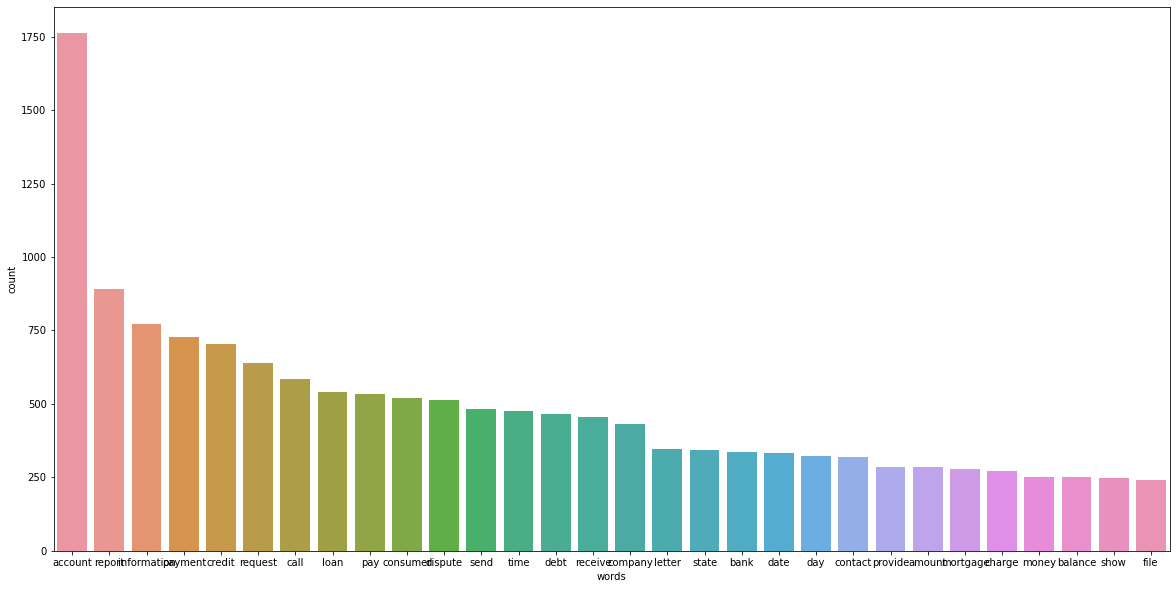

In [27]:
fig = plt.figure(1, figsize = (20,10))
# split() returns list of all the words in the string
split_it = realy_log_Text.split()
# Pass the split_it list to instance of Counter class.
Counter = Counter(split_it)
#print(Counter)
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common(30)
x_df = pd.DataFrame(most_occur, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = x_df)

# How many topics?
1. Let us start with a random number 4 as number of topics

In [28]:
lda_model_bow_4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [29]:
pprint(lda_model_bow_4.print_topics())

[(0,
  '0.030*"account" + 0.021*"payment" + 0.020*"report" + 0.019*"credit" + '
  '0.014*"request" + 0.011*"validation" + 0.010*"consumer" + '
  '0.009*"are_reporte" + 0.008*"information" + 0.008*"legal_right"'),
 (1,
  '0.033*"account" + 0.015*"information" + 0.015*"report" + 0.011*"dispute" + '
  '0.009*"send" + 0.009*"letter" + 0.007*"pay" + 0.007*"consumer" + '
  '0.007*"request" + 0.007*"credit"'),
 (2,
  '0.017*"loan" + 0.011*"call" + 0.010*"credit" + 0.008*"time" + '
  '0.008*"payment" + 0.007*"company" + 0.007*"charge" + 0.007*"receive" + '
  '0.006*"information" + 0.005*"state"'),
 (3,
  '0.012*"debt" + 0.011*"account" + 0.010*"pay" + 0.009*"call" + '
  '0.009*"receive" + 0.009*"mortgage" + 0.008*"loan" + 0.008*"payment" + '
  '0.008*"request" + 0.007*"money"')]


# What is the coherence of topic clusters

In [30]:
coherencemodel = CoherenceModel(model=lda_model_bow_4, texts=data_ready, dictionary=id2word, coherence='c_v')
print(coherencemodel.get_coherence())

0.32334884012687104


# Visualize the topic clusters

In [31]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_bow_4, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.017934  0.042946       1        1  42.303662
3      0.032165  0.063022       2        1  25.402034
0     -0.133256 -0.027793       3        1  19.360573
2      0.083158 -0.078176       4        1  12.933731, topic_info=           Term         Freq        Total Category  logprob  loglift
126      credit   635.000000   635.000000  Default  30.0000  30.0000
56         loan   510.000000   510.000000  Default  29.0000  29.0000
64      payment   651.000000   651.000000  Default  28.0000  28.0000
27      account  1636.000000  1636.000000  Default  27.0000  27.0000
180  validation   194.000000   194.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
18      provide    33.507463   271.305835   Topic4  -5.6047  -0.0461
112     request    36.144920   582.983545   Topic4  -5.5290  -0.7353
27      account    39.252867  1636.089121   Topic4  -5.4465  -1.6847
252      amount    32.530374   263.964718   Topic4  -5.6343  -0.0483
110      report    32.694062   815.142949   Topic4  -5.6293  -1.1708

[337 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2379      2  0.923600       accident
659       1  0.014714    accordingly
659       2  0.029428    accordingly
659       3  0.956413    accordingly
27        1  0.601434        account
...     ...       ...            ...
25        4  0.081536         verify
928       3  0.923423  was_designate
951       4  0.936530   wrong_person
952       4  0.936523  yet_feel_like
1433      1  0.945316      you_block

[602 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

# Visualization of documents to topics

In [32]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model_bow_4[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 996 samples in 0.001s...
[t-SNE] Computed neighbors for 996 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 996 / 996
[t-SNE] Mean sigma: 0.001777
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.438828
[t-SNE] KL divergence after 1000 iterations: 0.219200


/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


Loading BokehJS ...

/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


# Is there a way to Identify the BEST Coherent Clusters?

In [33]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_value = coherencemodel.get_coherence()
        print("number of topics ", num_topics, " has coherence value", coherence_value)
        coherence_values.append(coherence_value)

    return model_list, coherence_values

In [34]:
# this step will take some time to finish
model_list_bow, coherence_values_bow = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=42, step=2)

number of topics  2  has coherence value 0.31595064268380185
number of topics  4  has coherence value 0.32334884012687104
number of topics  6  has coherence value 0.35446550972223784
number of topics  8  has coherence value 0.3606992717791184
number of topics  10  has coherence value 0.3493030366891746
number of topics  12  has coherence value 0.35963848487920713
number of topics  14  has coherence value 0.3536170995324139
number of topics  16  has coherence value 0.3329734312218137
number of topics  18  has coherence value 0.3173133457823644
number of topics  20  has coherence value 0.32734302023951095
number of topics  22  has coherence value 0.32707992823074816
number of topics  24  has coherence value 0.3369962127652946
number of topics  26  has coherence value 0.3421284833765817
number of topics  28  has coherence value 0.31946072969531697
number of topics  30  has coherence value 0.3205723249741762
number of topics  32  has coherence value 0.3399026864750182
number of topics  34 

/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/harshit/miniconda

number of topics  38  has coherence value 0.3356521152480944
number of topics  40  has coherence value 0.32760999289266646


# Visualize Coherence

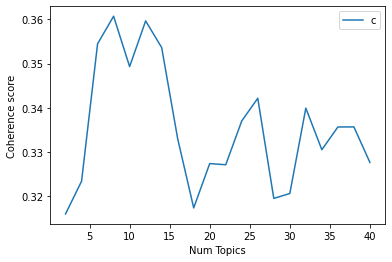

In [35]:
limit=42; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values_bow)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values_bow"), loc='best')
plt.show()

# Visualize the topic clusters = 8

In [36]:
vis = pyLDAvis.gensim_models.prepare(model_list_bow[3], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.031183  0.054425       1        1  21.228258
6      0.060536 -0.013908       2        1  20.468368
7      0.091577 -0.096285       3        1  14.064946
0      0.068197  0.001766       4        1  13.062929
3      0.041589  0.051197       5        1  10.443810
4     -0.301897 -0.013435       6        1  10.383113
5      0.015213 -0.101639       7        1   7.040976
2      0.055968  0.117878       8        1   3.307599, topic_info=            Term         Freq        Total Category  logprob  loglift
180   validation   204.000000   204.000000  Default  30.0000  30.0000
64       payment   693.000000   693.000000  Default  29.0000  29.0000
27       account  1657.000000  1657.000000  Default  28.0000  28.0000
56          loan   509.000000   509.000000  Default  27.0000  27.0000
126       credit   648.000000   648.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
89       dispute    12.652208   478.703368   Topic8  -5.2151  -0.2243
650         file    11.249247   224.306673   Topic8  -5.3326   0.4162
98   information    11.551908   722.182488   Topic8  -5.3061  -0.7265
546       remove    10.005064   159.457336   Topic8  -5.4498   0.6403
138      receive    10.029193   430.692725   Topic8  -5.4474  -0.3509

[614 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
181       1  0.193843         access
181       2  0.258457         access
181       3  0.016154         access
181       4  0.129228         access
181       5  0.032307         access
...     ...       ...            ...
197       6  0.005848           year
197       7  0.146200           year
197       8  0.023392           year
3033      3  0.869879         yearly
952       2  0.934118  yet_feel_like

[1537 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 8, 1, 4, 5, 6, 3])

# TFIDF Representation of Consumer Complaints

In [37]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [38]:
test_document = data_ready[0]
print("ACTUAL DOC=>\n",test_document)
print("====tfidf====")
tfidf_doc_0 = corpus_tfidf[0]
for i in range(len(tfidf_doc_0)):
    print("Word {} (\"{}\") weight {}.".format(tfidf_doc_0[i][0], 
                                               id2word[tfidf_doc_0[i][0]], tfidf_doc_0[i][1]))

ACTUAL DOC=>
 ['open', 'fraudulent', 'case', 'sit', 'month', 'decide', 'charge', 'submit', 'paperwork', 'state', 'order', 'exist', 'ship', 'house', 'order', 'number', 'provide', 'verify', 'lie', 'give', 'info', 'knowledge', 'trace', 'ip', 'address', 'ip', 'vanish', 'program']
====tfidf====
Word 0 ("address") weight 0.09677649988520717.
Word 1 ("case") weight 0.11065565911288751.
Word 2 ("charge") weight 0.09068640281510655.
Word 3 ("decide") weight 0.1477980909016056.
Word 4 ("exist") weight 0.1679797434512757.
Word 5 ("fraudulent") weight 0.10899328294205977.
Word 6 ("give") weight 0.08963477421983881.
Word 7 ("house") weight 0.15671399123691507.
Word 8 ("info") weight 0.16015097345340248.
Word 9 ("ip") weight 0.5932291083040911.
Word 10 ("knowledge") weight 0.1725038560051994.
Word 11 ("lie") weight 0.15671399123691507.
Word 12 ("month") weight 0.08566832346128754.
Word 13 ("number") weight 0.09930307298681793.
Word 14 ("open") weight 0.09677649988520717.
Word 15 ("order") weight 0.2

# Train LDA Model on TfIdf Corpus

In [41]:
lda_model_tfidf_2 = gensim.models.LdaMulticore(corpus_tfidf, num_topics=2, id2word=id2word, passes=10, workers=2)

In [42]:
coherencemodel_tfidf_2 = CoherenceModel(model=lda_model_tfidf_2, texts=data_ready, dictionary=id2word, coherence='c_v')
print(coherencemodel_tfidf_2.get_coherence())

0.35210112325434995


# Visualize the LDA topic on TfIdf corpus with 2 topics

In [43]:
vis = pyLDAvis.gensim_models.prepare(lda_model_tfidf_2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.026388  0.0       1        1  68.275977
0     -0.026388  0.0       2        1  31.724023, topic_info=            Term        Freq       Total Category  logprob  loglift
318   inaccurate   76.000000   76.000000  Default  30.0000  30.0000
165     consumer   95.000000   95.000000  Default  29.0000  29.0000
89       dispute  150.000000  150.000000  Default  28.0000  28.0000
167         debt  152.000000  152.000000  Default  27.0000  27.0000
642    incorrect   68.000000   68.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
472         name   42.001361   96.775649   Topic2  -6.2761   0.3134
1216      update   36.536842   72.960011   Topic2  -6.4154   0.4565
25        verify   36.309205   82.062822   Topic2  -6.4217   0.3327
114         send   39.123795  141.488716   Topic2  -6.3470  -0.1374
126       credit   39.157594  173.782294   Topic2  -6.3462  -0.3421

[148 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
27        1  0.574146   account
27        2  0.427272   account
120       1  0.920246     agent
120       2  0.069018     agent
229       1  0.932529     allow
...     ...       ...       ...
518       2  0.073690  was_told
523       1  0.931730      week
523       2  0.066552      week
1010      1  0.918413     wrong
1010      2  0.079862     wrong

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [44]:
def compute_coherence_values_multicore(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_value = coherencemodel.get_coherence()
        print("number of topics ", num_topics, " has coherence value", coherence_value)
        coherence_values.append(coherence_value)

    return model_list, coherence_values

In [45]:
model_list_tfidf, coherence_values_tfidf = compute_coherence_values_multicore(dictionary=id2word, corpus=corpus_tfidf, texts=data_ready, start=2, limit=42, step=2)

number of topics  2  has coherence value 0.2918390714073045
number of topics  4  has coherence value 0.3117765449040227
number of topics  6  has coherence value 0.3615700618338025
number of topics  8  has coherence value 0.3678048567306085
number of topics  10  has coherence value 0.4183303829657398
number of topics  12  has coherence value 0.486657757208473
number of topics  14  has coherence value 0.42893508162697686
number of topics  16  has coherence value 0.4358532800083714
number of topics  18  has coherence value 0.486139514380574
number of topics  20  has coherence value 0.5116685089646014
number of topics  22  has coherence value 0.5240826994515608
number of topics  24  has coherence value 0.4206296363791626
number of topics  26  has coherence value 0.5038002085949714
number of topics  28  has coherence value 0.5201153272123029
number of topics  30  has coherence value 0.5177006308462809
number of topics  32  has coherence value 0.4954599112501994
number of topics  34  has coh

/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/harshit/miniconda

number of topics  38  has coherence value 0.52157093657666
number of topics  40  has coherence value 0.5126170221595101


# Visualize Coherence

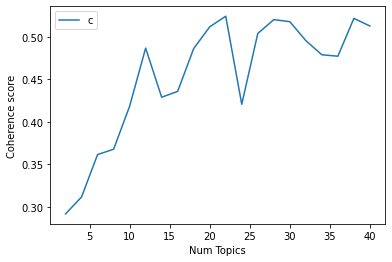

In [46]:
limit=42; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values_tfidf)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values_bow"), loc='best')
plt.show()

In [47]:
pprint(model_list_tfidf[10].print_topics())

[(20,
  '0.015*"consumer" + 0.011*"are_reporte" + 0.009*"validation" + '
  '0.008*"information" + 0.007*"section" + 0.007*"consumer_report" + '
  '0.007*"not_in_order" + 0.007*"laws_if_all" + 0.007*"then_have" + '
  '0.007*"inaccurate"'),
 (0,
  '0.067*"result" + 0.021*"day" + 0.008*"please_remove" + 0.006*"inaccurate" + '
  '0.005*"collection" + 0.004*"claim" + 0.004*"item" + 0.004*"are_not_mine" + '
  '0.004*"debt" + 0.003*"not_mine"'),
 (14,
  '0.005*"be_removed" + 0.004*"recently_checke" + 0.003*"voluntary" + '
  '0.003*"debit" + 0.003*"vehicle" + 0.003*"factual" + 0.003*"datum" + '
  '0.003*"cra" + 0.003*"be_remove" + 0.003*"steal"'),
 (15,
  '0.003*"anyrthe" + 0.003*"noice" + 0.003*"please_look" + 0.003*"lease" + '
  '0.003*"disclosure" + 0.002*"shellpoint" + 0.002*"pre" + '
  '0.002*"please_delete" + 0.002*"trans_union" + 0.002*"synchrony"'),
 (13,
  '0.010*"incorrect" + 0.009*"bureaus" + 0.009*"update" + 0.005*"mine" + '
  '0.004*"any_way" + 0.003*"swear" + 0.003*"inquiry_date"

# Visualize the LDA with 22 topics

In [48]:
vis = pyLDAvis.gensim_models.prepare(model_list_tfidf[10], corpus_tfidf, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.329040 -0.013795       1        1  48.368544
20     0.017120  0.158405       2        1   5.461072
4     -0.013711 -0.036473       3        1   4.564130
1     -0.008897 -0.016749       4        1   2.926450
3     -0.001305 -0.002179       5        1   2.758769
16    -0.030998 -0.013138       6        1   2.709670
6     -0.010467 -0.014855       7        1   2.673717
5      0.018277 -0.009436       8        1   2.613443
18    -0.004361 -0.010506       9        1   2.597508
9     -0.005427 -0.006801      10        1   2.439235
14    -0.031713 -0.002257      11        1   2.329183
0     -0.018598 -0.005987      12        1   2.295209
13    -0.015903 -0.010992      13        1   2.146334
2     -0.026342  0.004375      14        1   2.040710
7     -0.027108 -0.001541      15        1   2.029396
19    -0.013028  0.001506      16        1   1.994401
10    -0.029167 -0.002896      17        1   1.938276
21    -0.015546 -0.006269      18        1   1.884292
11    -0.027401 -0.006025      19        1   1.750086
12    -0.021289 -0.004849      20        1   1.568086
8     -0.032230 -0.001363      21        1   1.488250
15    -0.030946  0.001826      22        1   1.423239, topic_info=              Term       Freq      Total Category  logprob  loglift
277         result   8.000000   8.000000  Default  30.0000  30.0000
40             day  12.000000  12.000000  Default  29.0000  29.0000
5       fraudulent   9.000000   9.000000  Default  28.0000  28.0000
165       consumer  11.000000  11.000000  Default  27.0000  27.0000
1216        update   7.000000   7.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
2674       navient   0.123686   0.973089  Topic22  -6.3578   2.1895
3799  did_not_open   0.125296   1.169958  Topic22  -6.3448   2.0182
491       property   0.124381   1.494218  Topic22  -6.3521   1.7662
180     validation   0.136455   3.858333  Topic22  -6.2595   0.9102
198      authorize   0.119794   1.822633  Topic22  -6.3897   1.5300

[1075 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
980       1  0.884907         accord
659       2  0.671257    accordingly
27        1  0.831340        account
27        2  0.037788        account
27        5  0.037788        account
...     ...       ...            ...
951      14  1.055392   wrong_person
197       1  0.940493           year
340       1  0.664864            yet
340       8  0.166216            yet
952      14  1.055389  yet_feel_like

[327 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 21, 5, 2, 4, 17, 7, 6, 19, 10, 15, 1, 14, 3, 8, 20, 11, 22, 12, 13, 9, 16])